# 使用手寫辨識資料集, 觀察 PCA 算法

# [作業目標]
- 試著模仿範例寫法, 以變更參數後的 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

# [作業重點]
- 以手寫辨識資料集, 觀察變更參數後的 PCA 算法, 在取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [17]:
# 載入套件
import numpy as np #產生陣列數值
import matplotlib.pyplot as plt #用來繪製影像
import pandas as pd

from sklearn import datasets #用來匯入資料庫
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [18]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
'''
核心函數: sklearn.linear_model.SGDClassifier

參數:
loss ：指定損失函數。  ("log"-邏輯回歸)
penalty:罰項類型。  ("l2": L2 norm penalty on coef_)
max_iter：迭代的最大次數，只影響fit方法，預設值為5。
tol：訓練結束的誤差邊界。
random_state: 為了保證每次運行時都是相同方式進行分割。


參考來源: https://www.cnblogs.com/lc1217/p/7085034.html
參考來源: https://zhuanlan.zhihu.com/p/60983320
'''
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
"""
Pipeline
參數:
steps:一些列需要成鏈的過程，最後是評估量。

參考來源:https://www.twblogs.net/a/5d126ae3bd9eee1ede04d179
"""

# 載入手寫數字辨識集
#digits = datasets.load_digits() 將一個dict型別資料存入digits
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [19]:
# 先執行 GridSearchCV 跑出最佳參數
## GridSearchCV，它存在的意義就是自動調整參數
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)
    """
    GridSearchCV
    參數:
    estimator: 使用的分類器
    param_grid: list 或是 dict 做最佳化的參數。
    iid: 設置為True時即假設在折疊中樣本概率分佈一致，損失估計為所有樣本總合，而非平均。
    cv:預設為3，交叉驗證，將資料分n份。
    return_train_score: 如果設置False就不會回傳結果!。

    參考來源:https://martychen920.blogspot.com/2017/09/ml-gridsearchcv.html
    """
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


IndentationError: unexpected indent (<ipython-input-19-59e725286f48>, line 8)

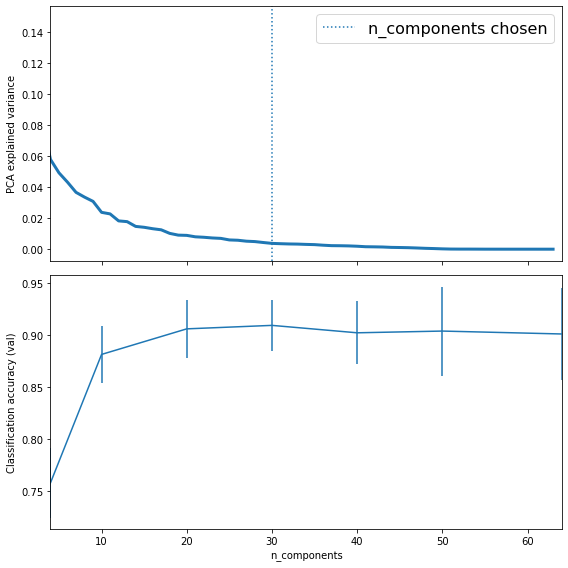

In [20]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits)

#plt.subplots(sharex): 布林值，控制x(sharex)軸之間的屬性共享
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8)) 
ax0.plot(pca.explained_variance_ratio_, linewidth=3)
ax0.set_ylabel('PCA explained variance')

#ax0.axvline創造一條垂直直線
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
#ax0.legend圖例，prop:字體參數
ax0.legend(prop=dict(size=16))

# 繪製不同採樣點的分類正確率
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)') # 設定y軸標籤
ax1.set_xlabel('n_components') #設定x軸標籤

#圖表過度集中可以使用.tight_layout分開
plt.tight_layout()
plt.show()